In [77]:
import sqlite3
import numpy as np
import pandas as pd
import sqlalchemy
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from prophet import Prophet

conexion = sqlite3.connect('C:/Users/305709/Downloads/datos.db')

#archivos = {
#    'C:/Users/305709/Downloads/victimasFGJ_acumulado_2024_09 Depurado.csv': 'tablaPrincipal',
#    'C:/Users/305709/Downloads/BD_Colonias.csv': 'tablaColonias',
#    'C:/Users/305709/Downloads/BD_Alcaldias.csv': 'tablaAlcaldias'
#}

#for archivo, tabla in archivos.items():
#    df = pd.read_csv(archivo)
#    df.to_sql(tabla, conexion, if_exists='replace', index=False)
#    

cursor = conexion.cursor()




In [ ]:
# para reemplazar celdas

cursor.execute('''
                UPDATE tablaPrincipal
                SET hora_hecho = hora_inicio
                WHERE hora_hecho IS NULL     
               ''')
conexion.commit()
conexion.close

<function Connection.close()>

In [78]:
# Para hacer el dataframe del pronóstico dados los criterios


cursor.execute('''
                SELECT
                     P.fecha_hecho AS Fecha, COUNT(*) AS Recuento
                FROM tablaPrincipal P
                JOIN tablaAlcaldias A
                    ON P.id_alcaldia_hecho = A.alcaldia_id
                JOIN tablaColonias C
                    ON P.id_colonia_hecho = C.colonia_id
                WHERE
                    P.categoria_delito = "DELITO DE BAJO IMPACTO"
                    AND C.Colonia = "INFONAVIT IZTACALCO"
                    AND A.Alcaldia = "IZTACALCO"
                GROUP BY P.fecha_hecho
                ORDER BY
                    P.fecha_hecho
               ''')

conexion.commit()
resultados = cursor.fetchall()
columnas = [descripcion[0] for descripcion in cursor.description]

dfAgrupado = pd.DataFrame(resultados, columns=columnas)

dfAgrupado["Fecha"] = pd.to_datetime(dfAgrupado["Fecha"])

fechas =pd.date_range(start='2023-01-01', end='2024-09-16')

dfFechas = pd.DataFrame({"Fecha":fechas})
dfFechas["Fecha"] = pd.to_datetime(dfFechas["Fecha"])

dfTotal = pd.merge(dfFechas, dfAgrupado, how="left", on=['Fecha'])
dfTotal['Recuento']=dfTotal['Recuento'].fillna(0)




In [79]:
dfTotal['Recuento'].value_counts()



Recuento
0.0    273
1.0    194
2.0    103
3.0     41
4.0      7
5.0      6
6.0      1
Name: count, dtype: int64

In [ ]:

# Para hacer el dataframe de las colonias por alcaldia

cursor.execute('''
                SELECT DISTINCT
                     C.Colonia
                FROM tablaPrincipal P
                JOIN tablaAlcaldias A
                    ON P.id_alcaldia_hecho = A.alcaldia_id
                JOIN tablaColonias C
                    ON P.id_colonia_hecho = C.colonia_id
                WHERE 
                    A.Alcaldia = "XOCHIMILCO"

                GROUP BY 1
                ORDER BY 1
               ''')

conexion.commit()
resultados = cursor.fetchall()
columnas = [descripcion[0] for descripcion in cursor.description]

df = pd.DataFrame(resultados, columns=columnas)
df

,Colonia
0,ACOCA
1,ACUEDUCTO XOCHIMILCO
2,ALCANFORES
3,ALDAMA
4,ALTOS TEPETLICA
...,...
135,VASO DE REGULACION
136,VILLA DE LA NORIA
137,XOCHIMILCO
138,XOCHIPILLI


In [80]:
# Para hacer el dataframe de los delitos

cursor.execute('''
                SELECT DISTINCT
                     P.categoria_delito
                FROM tablaPrincipal P
                ORDER BY 1
               ''')

conexion.commit()
resultados = cursor.fetchall()
columnas = [descripcion[0] for descripcion in cursor.description]

df = pd.DataFrame(resultados, columns=columnas)
df

,categoria_delito
0,DELITO DE BAJO IMPACTO
1,HECHO NO DELICTIVO
2,HOMICIDIO DOLOSO
3,LESIONES DOLOSAS POR DISPARO DE ARMA DE FUEGO
4,ROBO A CASA HABITACION CON VIOLENCIA
5,ROBO A CASA HABITACIoN CON VIOLENCIA
6,ROBO A CUENTAHABIENTE SALIENDO DEL CAJERO CON ...
7,ROBO A NEGOCIO CON VIOLENCIA
8,ROBO A PASAJERO A BORDO DE MICROBUS CON Y SIN ...
9,ROBO A PASAJERO A BORDO DE TAXI CON VIOLENCIA


20:42:07 - cmdstanpy - INFO - Chain [1] start processing
20:42:08 - cmdstanpy - INFO - Chain [1] done processing


            ds
630 2024-09-22
631 2024-09-23
632 2024-09-24
633 2024-09-25
634 2024-09-26


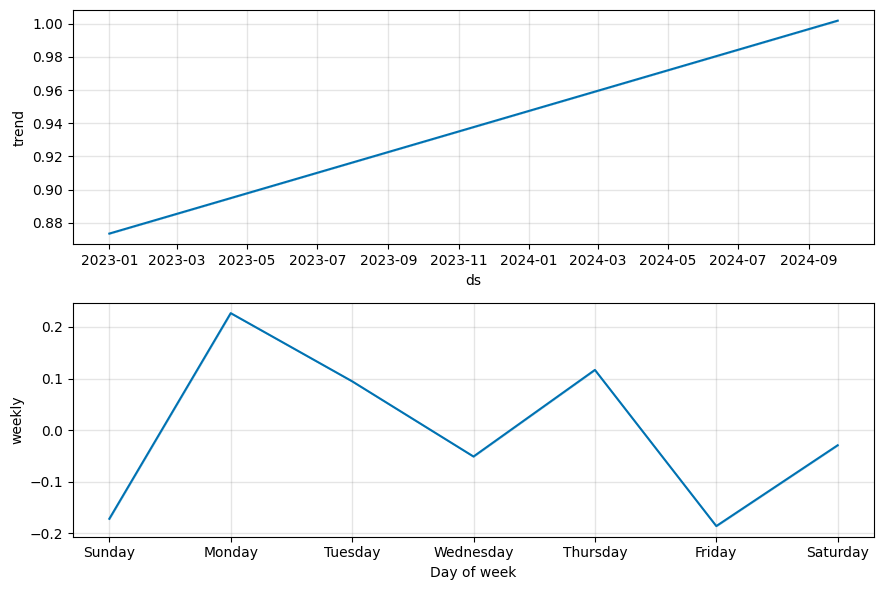

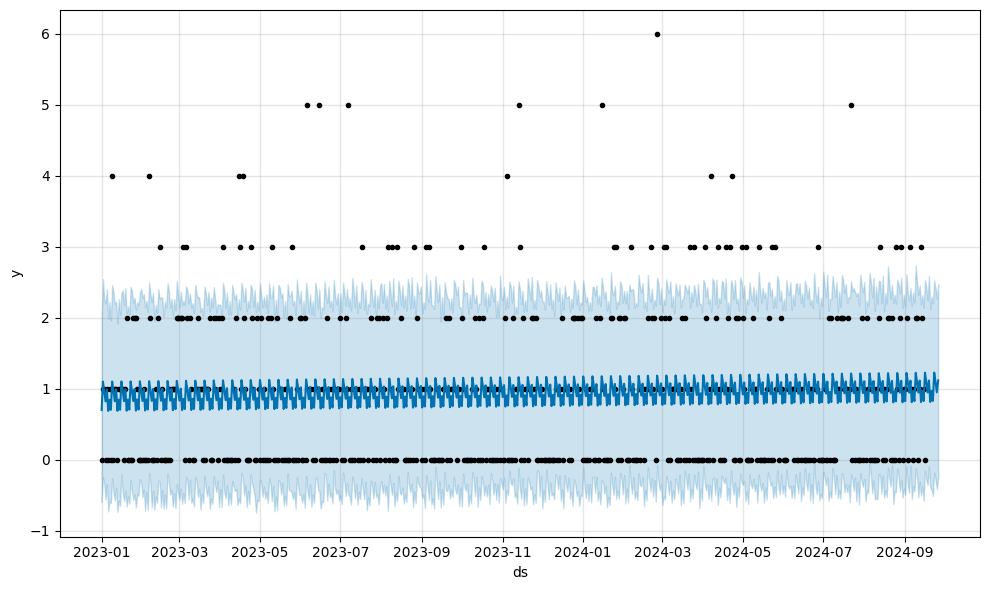

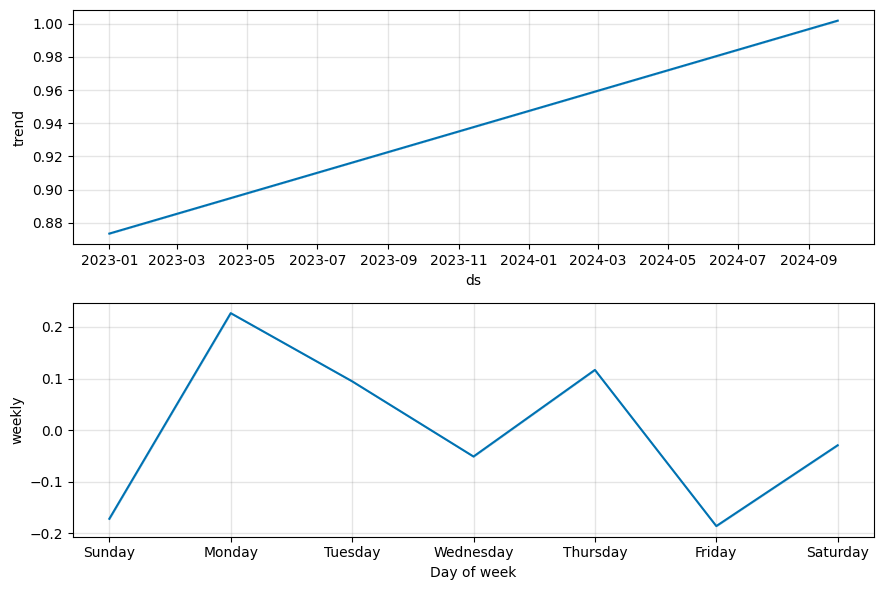

In [81]:
#  MODELO PROPHET


dfTotal['Fecha'] = pd.to_datetime(dfTotal['Fecha'])


# 1. Renombrar las columnas como las necesita Prophet
df_prophet = dfTotal.rename(columns={'Fecha': 'ds', 'Recuento': 'y'})

#2. Entrenar el modelo y hacer predicciones 
#from prophet import Prophet

# Crear el modelo

model = Prophet()

# Ajustar el modelo a los datos
model.fit(df_prophet)

# crear un DF con el pronóstico a 10 días
future = model.make_future_dataframe(periods=10)

#3. Ver el dataframe con fechas futuras
print(future.tail())

#4.  Generar el pronóstico

forecast = model.predict(future)

#5. Visualizar los resultados

model.plot(forecast)

# Componentes: tendencia, estacionalidad, etc
model.plot_components(forecast)


In [82]:
# MODELO ARIMA

from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt

modeloARIMA = ARIMA(dfTotal['Recuento'], order=(7, 3, 7))
modeloEntrenado = modeloARIMA.fit()

C:\Users\305709\AppData\Roaming\Python\Python313\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\305709\AppData\Roaming\Python\Python313\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


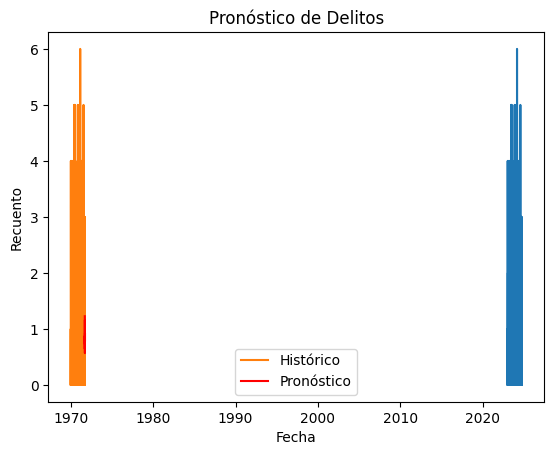

In [83]:
pronostico = modeloEntrenado.forecast(steps=10)

import seaborn as sns
import statsmodels.api as sm



plt.Figure(figsize=(20, 15))
sns.lineplot(x=dfTotal["Fecha"], y=dfTotal['Recuento']) 

plt.plot(dfTotal['Recuento'], label='Histórico')
plt.plot(pronostico.index, pronostico, label='Pronóstico', color='red')
plt.legend()
plt.title('Pronóstico de Delitos')
plt.show()


In [67]:
pronostico


625    1.226528
626    0.643474
627    0.877023
628    0.842234
629    0.568425
630    1.160971
631    0.725702
632    0.798147
633    0.925248
634    0.796156
Name: predicted_mean, dtype: float64